In [1]:
from __future__ import print_function
import os
from PIL import Image
import numpy as np
import tensorflow
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import img_to_array,load_img
from keras.models import load_model

/var/web_services/galaxy/jupyter_conda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(232)

In [3]:
path_test='test_kaggle/images/'

In [ ]:
#test_ids = sorted(os.listdir(path_test))

df = pd.read_csv('sample_submission.csv', index_col="id")
result=(df.index.values)
result = [str(i)+'.png' for i in result]
test_ids = result


In [4]:
test_ids = sorted(os.listdir(path_test))

NameError: name 'pd' is not defined

In [5]:
im_chan=1
image_width=128
image_height=128

# Get and resize test images
X_test =  np.ndarray((len(test_ids), image_width, image_height), dtype=np.uint8)
sizes_test = []
empty_imgs_ind=[]
print('Getting and resizing test images ... ')
for n, id_ in enumerate(test_ids):
    img = Image.open(os.path.join(path_test,id_)).convert('L') 
    img = np.array(img.resize((image_height,image_width)))
    X_test[n] = img
    #print(n,id_)
    if np.max(np.array(img))-np.min(np.array(img))==0:
        empty_imgs_ind.append(n)
   

np.save('X_test.npy', X_test)
print('Done!')

Getting and resizing test images ... 
Done!


In [6]:
X_test = np.load('X_test.npy')
X_test = X_test[:,:,:,np.newaxis]
X_test = X_test.astype('float32')
X_test /=255.0

In [7]:
model = load_model('checkpoint/keras.model')

In [8]:
preds_test=model.predict(X_test)

In [9]:
# Create list of resized test masks
preds_test_resized = []
target_size=101
preds_test_resized = np.ndarray((len(X_test), target_size, target_size), dtype=np.float32)
n=0
preds_test=np.squeeze(preds_test)
for n, id_ in enumerate(test_ids):
    img=Image.fromarray(preds_test[n])
    img = np.array(img.resize((target_size,target_size)))
    preds_test_resized[n] = img
    n +=1

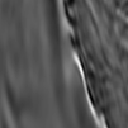

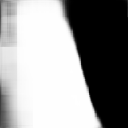

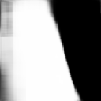

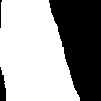

In [11]:
nn=13400

imgs_test=X_test[nn].reshape(128,128)
imgtest=Image.fromarray(255*imgs_test).convert('RGB').convert('L')
display(imgtest)


imgs_test=preds_test[nn].reshape(128,128)
imgtest=Image.fromarray(255*imgs_test).convert('RGB').convert('L')
display(imgtest)


imgs_test=preds_test_resized[nn]
imgtest=Image.fromarray(255*imgs_test).convert('RGB').convert('L')
display(imgtest)

imgs_test=preds_test_resized[nn]
imgs_test=np.round(imgs_test)
imgtest=Image.fromarray(255*imgs_test).convert('RGB').convert('L')
display(imgtest)

In [12]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [20]:
#remove masks of blank images 
for ind in empty_imgs_ind:
    preds_test_resized[ind]=np.zeros((target_size,target_size),dtype=np.float32)


In [21]:
preds_test_resized.shape

(18000, 101, 101)

In [22]:
len(test_ids)


18000

In [23]:
pred_dict = {fn[:-4]:RLenc(np.round(preds_test_resized[i])) for i,fn in enumerate(test_ids)}

In [24]:
len(pred_dict)

18000

In [144]:
import pandas as pd
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

NameError: name 'pd' is not defined